In [16]:
# Cell 1 — Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import re
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")

# set nicer default figure size
plt.rcParams['figure.figsize'] = (10,5)


In [17]:
df = pd.read_csv("Family-Income-and-Expenditure.csv")

In [19]:
print("Rows, cols:", df.shape)
print("Columns sample:", df.columns[:10].tolist())
df.head()

Rows, cols: (41544, 60)
Columns sample: ['Total Household Income', 'Region', 'Total Food Expenditure', 'Main Source of Income', 'Agricultural Household indicator', 'Bread and Cereals Expenditure', 'Total Rice Expenditure', 'Meat Expenditure', 'Total Fish and  marine products Expenditure', 'Fruit Expenditure']


,Total Household Income,Region,Total Food Expenditure,Main Source of Income,Agricultural Household indicator,Bread and Cereals Expenditure,Total Rice Expenditure,Meat Expenditure,Total Fish and marine products Expenditure,Fruit Expenditure,...,Number of Refrigerator/Freezer,Number of Washing Machine,Number of Airconditioner,"Number of Car, Jeep, Van",Number of Landline/wireless telephones,Number of Cellular phone,Number of Personal Computer,Number of Stove with Oven/Gas Range,Number of Motorized Banca,Number of Motorcycle/Tricycle
0,480332,CAR,117848,Wage/Salaries,0,42140,38300,24676,16806,3325,...,1,1,0,0,0,2,1,0,0,1
1,198235,CAR,67766,Wage/Salaries,0,17329,13008,17434,11073,2035,...,0,1,0,0,0,3,1,0,0,2
2,82785,CAR,61609,Wage/Salaries,1,34182,32001,7783,2590,1730,...,0,0,0,0,0,0,0,0,0,0
3,107589,CAR,78189,Wage/Salaries,0,34030,28659,10914,10812,690,...,0,0,0,0,0,1,0,0,0,0
4,189322,CAR,94625,Wage/Salaries,0,34820,30167,18391,11309,1395,...,1,0,0,0,0,3,0,0,0,1


In [20]:
# Cell 3 — Inspect and prepare key columns
print("Key columns we will use:")
for c in ["Total Household Income", "Region", "Household Head Highest Grade Completed"]:
    print("-", c, "-> present?" , c in df.columns)

# Make a working copy
data = df.copy()
# Standardize column names (optional)
data.columns = [c.strip() for c in data.columns]


Key columns we will use:
- Total Household Income -> present? True
- Region -> present? True
- Household Head Highest Grade Completed -> present? True


In [21]:
# Cell 4 — Convert 'Total Household Income' to numeric (cleaning)
income_col = "Total Household Income"
edu_col = "Household Head Highest Grade Completed"
region_col = "Region"

# Clean income (remove commas/spaces if strings)
data[income_col] = pd.to_numeric(data[income_col], errors='coerce')
print("Income: missing values:", data[income_col].isna().sum())

# Drop rows missing essential info
data = data.dropna(subset=[income_col, edu_col, region_col]).reset_index(drop=True)
print("After dropping NA rows, shape:", data.shape)


Income: missing values: 0
After dropping NA rows, shape: (41544, 60)


In [22]:
# Cell 5 — Map education text to approximate years of schooling
def edu_to_years(text):
    if pd.isna(text):
        return np.nan
    s = str(text).lower()
    # look for explicit 'grade X'
    m = re.search(r'grade\s*(\d+)', s)
    if m:
        return int(m.group(1))
    # elementary graduate -> 6
    if "elementary graduate" in s or "elementary" in s and "graduate" in s:
        return 6
    # first/second/third year high school etc
    m = re.search(r'(\bfirst\b|\b1st\b|\bsecond\b|\b2nd\b|\bthird\b|\b3rd\b|\bfourth\b|\bfourth\b)\s*year', s)
    if m:
        token = m.group(1)
        if token.startswith('first') or token.startswith('1'):
            return 7  # 1st year HS -> year 7
        if token.startswith('second') or token.startswith('2'):
            return 8
        if token.startswith('third') or token.startswith('3'):
            return 9
            
        if token.startswith('fourth') or token.startswith('4'):
            return 10
    # high school graduate
    if "high school graduate" in s or "high school" in s and "graduate" in s:
        return 12
    # first year college / second year / third year
    m = re.search(r'first year college|second year college|third year college|fourth year college|first year university', s)
    if "first year" in s and ("college" in s or "university" in s):
        return 13
    if "second year" in s and ("college" in s or "university" in s):
        return 14
    if "third year" in s and ("college" in s or "university" in s):
        return 15
    if "fourth year" in s and ("college" in s or "university" in s):
        return 16
    # college graduate / bachelor
    if "graduate" in s and ("college" in s or "university" in s or "bachelor" in s):
        return 16
    # vocational or training programs: approximate mapping
    if "training" in s or "technical" in s or "trade" in s:
        return 12
    # master's / postgrad
    if "master" in s or "postgraduate" in s or "masters" in s:
        return 18
    if "doctoral" in s or "phd" in s or "doctor" in s:
        return 21
    # fallback: try to find any number in text
    m = re.search(r'(\d+)', s)
    if m:
        val = int(m.group(1))
        # sanity: treat numeric less than 30 as years/grade
        if 1 <= val <= 21:
            return val
    # As a last resort classify as median (10)
    return np.nan

# Apply mapping
data["education_years"] = data[edu_col].apply(edu_to_years)
print("Converted education -> years, missing:", data["education_years"].isna().sum())
data[["Household Head Highest Grade Completed", "education_years"]].head(10)


Converted education -> years, missing: 4785


,Household Head Highest Grade Completed,education_years
0,Teacher Training and Education Sciences Programs,12.0
1,Transport Services Programs,NaN
2,Grade 3,3.0
3,Elementary Graduate,6.0
4,Elementary Graduate,6.0
5,Second Year High School,8.0
6,Third Year High School,9.0
7,Business and Administration Programs,NaN
8,First Year College,7.0
9,High School Graduate,12.0


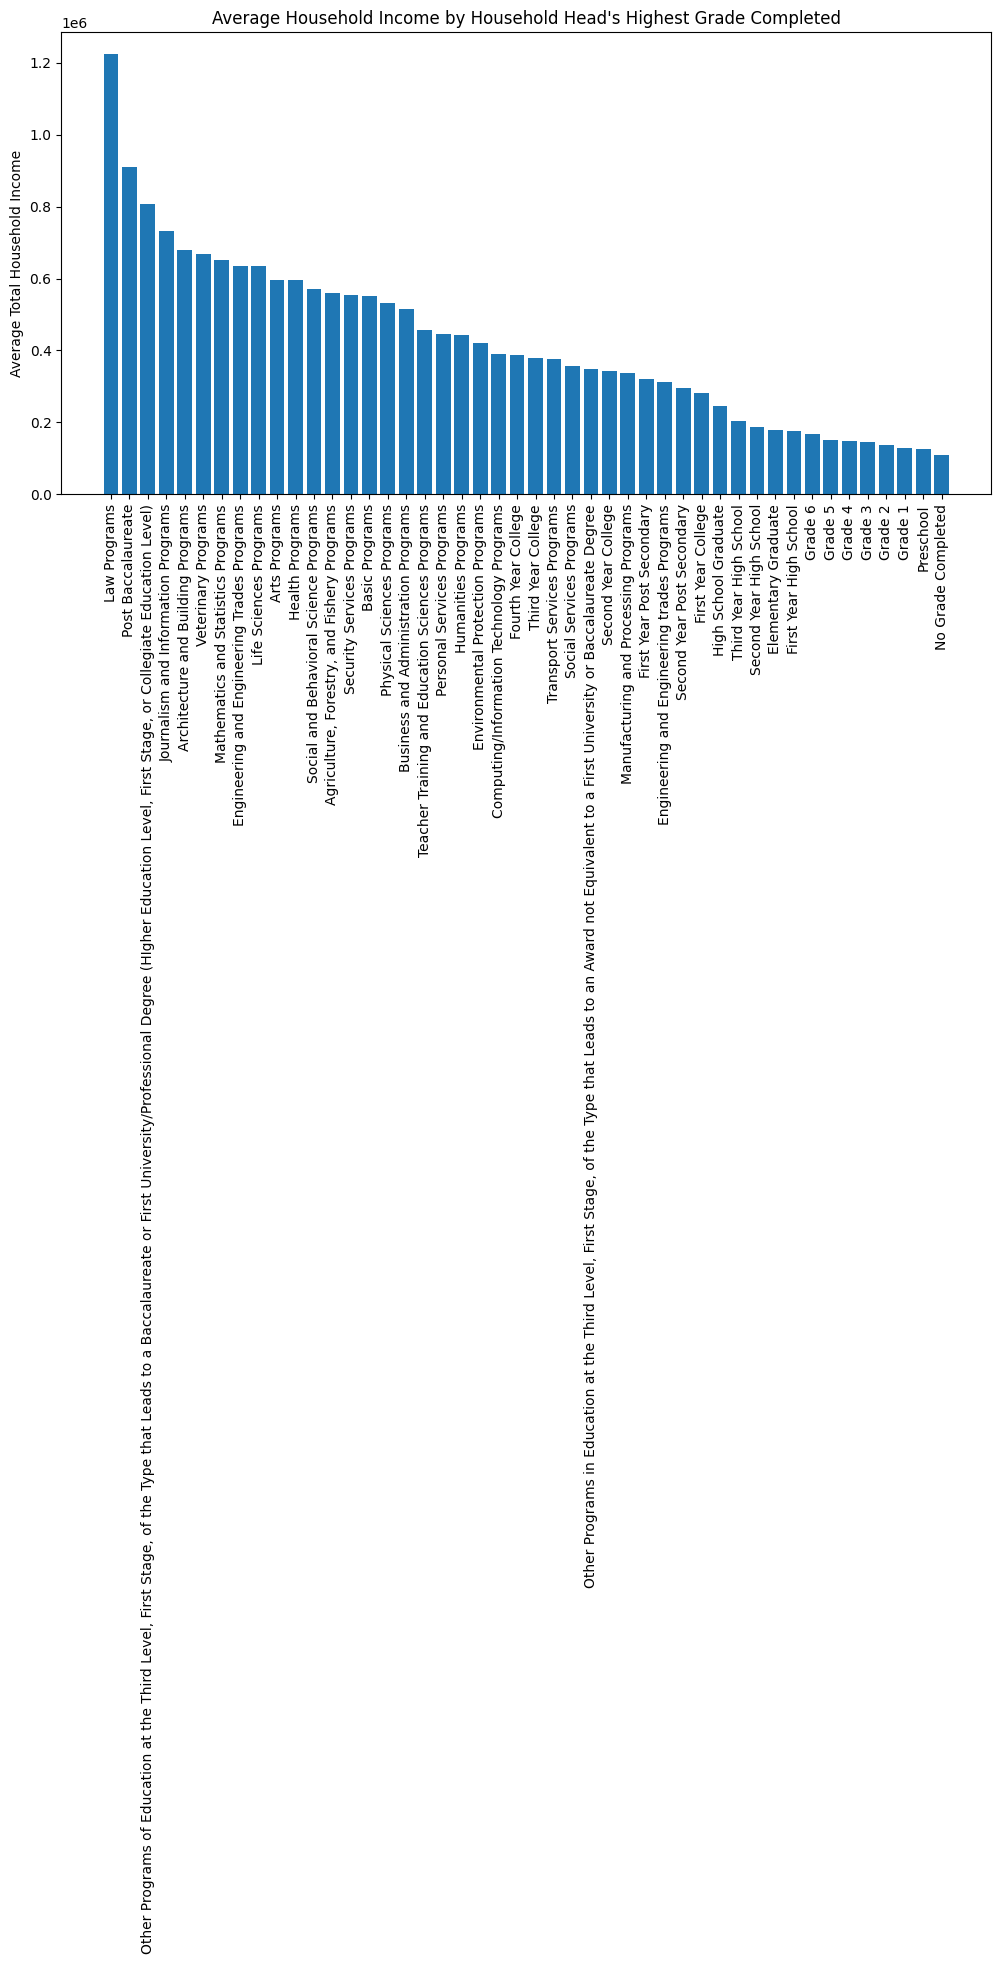

In [23]:
# Cell 6 — DESCRIPTIVE 1: Average income by education level (grouped)
group = data.groupby(edu_col)[income_col].mean().sort_values(ascending=False).reset_index()
plt.figure(figsize=(12,6))
plt.bar(group[edu_col].astype(str), group[income_col])
plt.xticks(rotation=90)
plt.ylabel("Average Total Household Income")
plt.title("Average Household Income by Household Head's Highest Grade Completed")
plt.tight_layout()
plt.show()


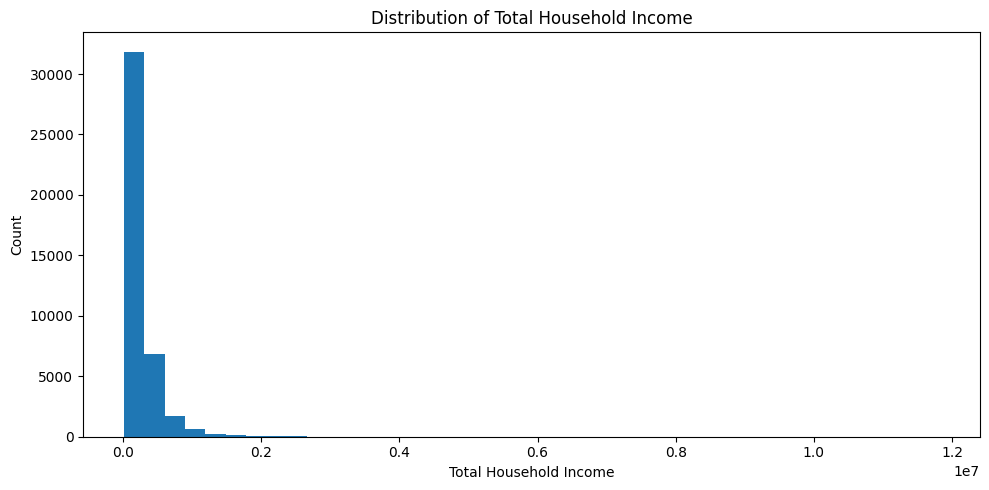

  edu_bucket  count           mean    median
0        <=6  16461  161089.428224  124477.0
1       7-10   8449  250504.527873  179497.0
2      11-12  11849  290948.265845  209600.0
3      12-13      0            NaN       NaN
4      13-15      0            NaN       NaN
5         16      0            NaN       NaN
6        16+      0            NaN       NaN


In [24]:
# Cell 7 — DESCRIPTIVE 2: Income distribution overall (histogram) and by education-years bucket
plt.figure()
plt.hist(data[income_col].dropna(), bins=40)
plt.title("Distribution of Total Household Income")
plt.xlabel("Total Household Income")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# bucket education years for summary
data['edu_bucket'] = pd.cut(data['education_years'], bins=[0,6,10,12,13.5,16,20,100],
                           labels=["<=6","7-10","11-12","12-13","13-15","16","16+"])
summary = data.groupby('edu_bucket')[income_col].agg(['count','mean','median']).reset_index()
print(summary)


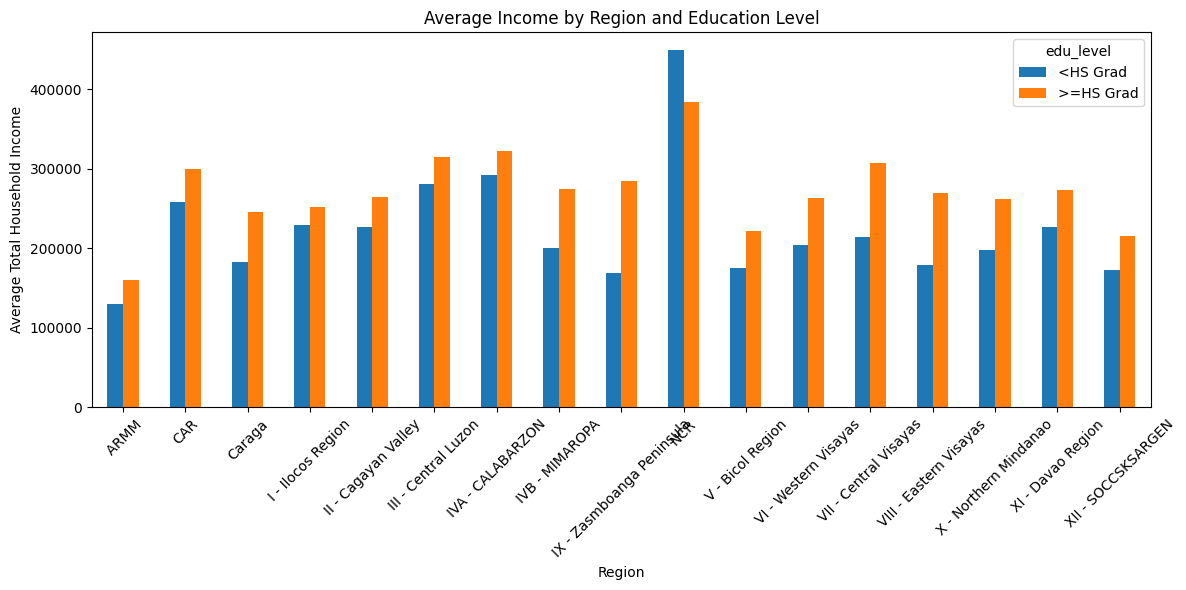

In [25]:
# Cell 8 — DESCRIPTIVE 3: Region vs Education — mean income per region for low/high education
# define low vs high education
data['edu_level'] = np.where(data['education_years'] >= 12, '>=HS Grad', '<HS Grad')
reg_mean = data.groupby([region_col,'edu_level'])[income_col].mean().unstack()
reg_mean.plot(kind='bar', figsize=(12,6))
plt.title("Average Income by Region and Education Level")
plt.ylabel("Average Total Household Income")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


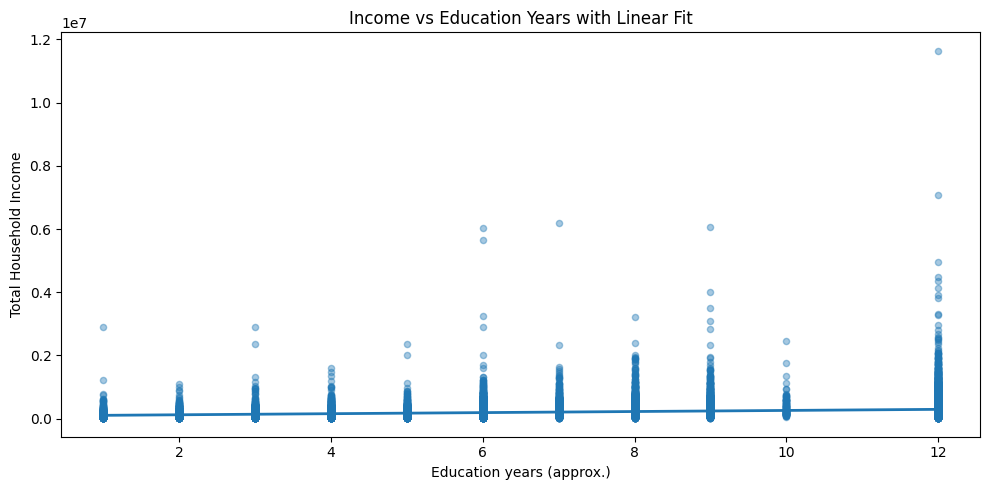

Linear regression slope (income per additional year): 17190.51192536028
Intercept: 89418.72660757988
R^2: 0.06136754517105347


In [26]:
# Cell 9 — DIAGNOSTIC 1: Correlation between education_years and income (scatter + regression line)
# Keep rows with valid numeric education_years
sub = data.dropna(subset=['education_years', income_col])
X = sub['education_years'].values.reshape(-1,1)
y = sub[income_col].values

# Fit linear regression
lr = LinearRegression()
lr.fit(X,y)
pred = lr.predict(X)

plt.figure()
plt.scatter(X, y, alpha=0.4, s=20)
# regression line (sorted for plotting)
idx = np.argsort(X[:,0])
plt.plot(X[idx], pred[idx], linewidth=2)
plt.xlabel("Education years (approx.)")
plt.ylabel("Total Household Income")
plt.title("Income vs Education Years with Linear Fit")
plt.tight_layout()
plt.show()

print("Linear regression slope (income per additional year):", lr.coef_[0])
print("Intercept:", lr.intercept_)
print("R^2:", r2_score(y, pred))


In [27]:
# Cell 10 — DIAGNOSTIC 2: Statistical test — OLS regression (log income to reduce skew)
# Use statsmodels OLS to show significance
sub['log_income'] = np.log1p(sub[income_col])
X_sm = sm.add_constant(sub['education_years'])
model = sm.OLS(sub['log_income'], X_sm).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:             log_income   R-squared:                       0.121
Model:                            OLS   Adj. R-squared:                  0.121
Method:                 Least Squares   F-statistic:                     5037.
Date:                Thu, 04 Dec 2025   Prob (F-statistic):               0.00
Time:                        20:51:32   Log-Likelihood:                -37770.
No. Observations:               36759   AIC:                         7.554e+04
Df Residuals:                   36757   BIC:                         7.556e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              11.4540      0.009   12

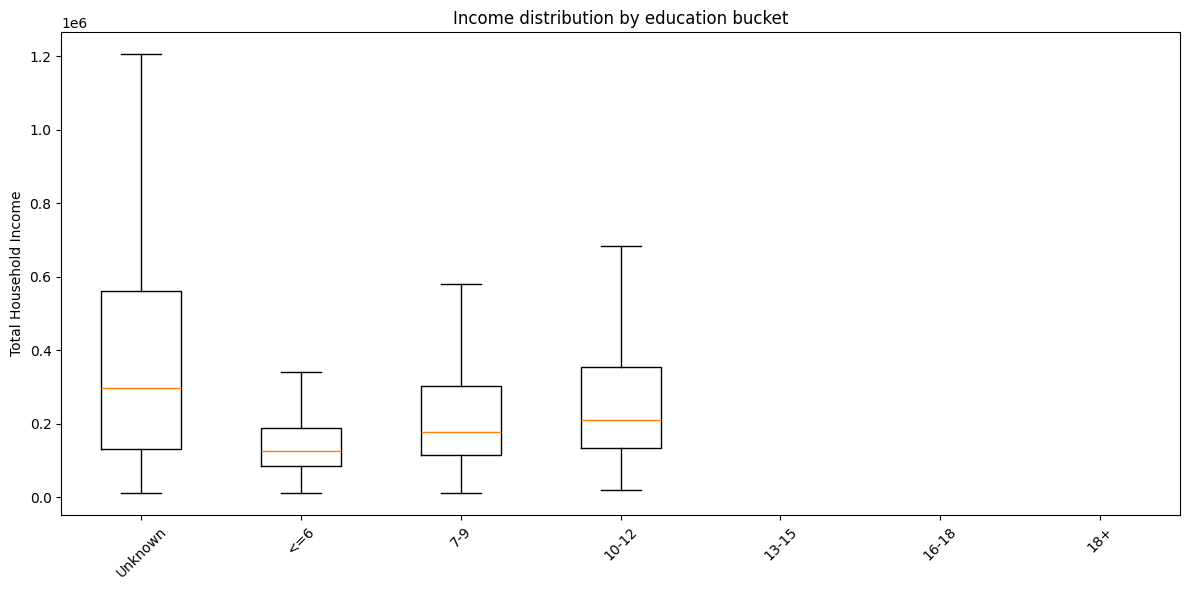

In [28]:
# Cell 11 — DIAGNOSTIC 3: Boxplots to show income spread by education bucket
# prepare buckets (more granular)
data['edu_bucket2'] = pd.cut(data['education_years'].fillna(-1),
                            bins=[-2,0,6,9,12,15,18,25],
                            labels=["Unknown","<=6","7-9","10-12","13-15","16-18","18+"])
plt.figure(figsize=(12,6))
# build lists for boxplot (matplotlib)
labels = data['edu_bucket2'].cat.categories.tolist()
box_data = [data.loc[data['edu_bucket2']==lab, income_col].dropna().values for lab in labels]
plt.boxplot(box_data, labels=labels, showfliers=False)
plt.title("Income distribution by education bucket")
plt.ylabel("Total Household Income")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [29]:
# Cell 12 — PREDICTIVE 1: Build predictive model (Education -> Income)
# Because income is skewed, you can model log(income)
sub2 = sub.copy()
X = sub2[['education_years']]
y_log = np.log1p(sub2[income_col])
lr2 = LinearRegression()
lr2.fit(X, y_log)
y_log_pred = lr2.predict(X)
y_pred = np.expm1(y_log_pred)

print("Model coef (log-income per education year):", lr2.coef_[0])
print("R^2 (log-model):", r2_score(y_log, y_log_pred))


Model coef (log-income per education year): 0.07401447677949195
R^2 (log-model): 0.12052909574583681


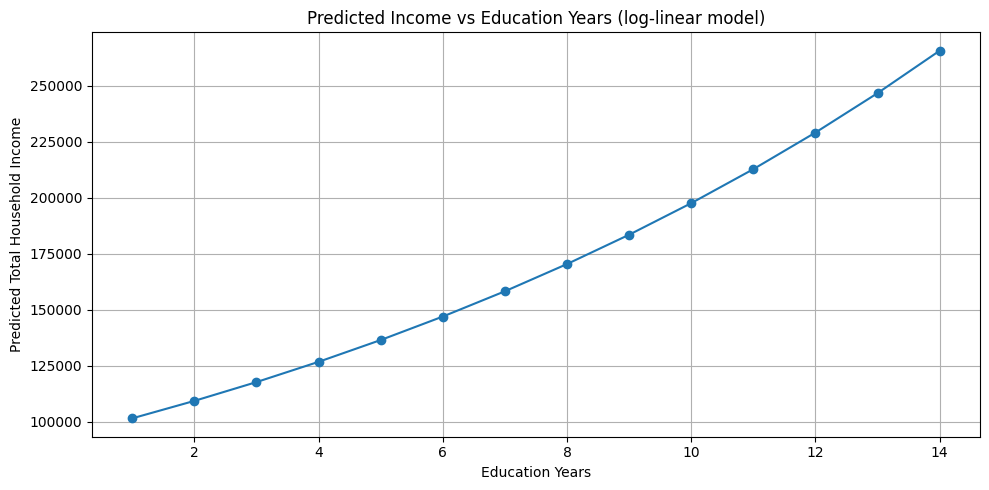

In [30]:
# Cell 13 — PREDICTIVE 2: Visualize predicted income across a range of education years
years = np.arange(int(np.nanmin(data['education_years'].dropna())), int(np.nanmax(data['education_years'].dropna()))+3)
years = years.reshape(-1,1)
pred_log = lr2.predict(years)
pred_income = np.expm1(pred_log)

plt.figure()
plt.plot(years, pred_income, marker='o')
plt.xlabel("Education Years")
plt.ylabel("Predicted Total Household Income")
plt.title("Predicted Income vs Education Years (log-linear model)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [31]:
# Cell 14 — PREDICTIVE 3: Scenario simulation — what if avg education increases +2 years?
current_avg = sub2['education_years'].mean()
future_avg = current_avg + 2
current_pred_log = lr2.predict(np.array([[current_avg]]))[0]
future_pred_log = lr2.predict(np.array([[future_avg]]))[0]
current_pred_income = np.expm1(current_pred_log)
future_pred_income = np.expm1(future_pred_log)
print("Current avg education (years):", round(current_avg,2))
print("Projected avg education if +2 years:", round(future_avg,2))
print("Predicted avg household income now (model):", round(current_pred_income,2))
print("Predicted avg household income if +2 years:", round(future_pred_income,2))
print("Absolute change:", round(future_pred_income - current_pred_income,2))
print("Percent change:", round(100*(future_pred_income/current_pred_income - 1),2), "%")


Current avg education (years): 7.8
Projected avg education if +2 years: 9.8
Predicted avg household income now (model): 167928.15
Predicted avg household income if +2 years: 194720.66
Absolute change: 26792.5
Percent change: 15.95 %


In [32]:
# Cell 15 — Summary outputs to copy into your infographic (aggregates)
agg_by_edu = data.groupby('edu_bucket')[income_col].agg(['count','mean','median']).reset_index()
agg_by_region = data.groupby(region_col)[income_col].median().sort_values(ascending=False).reset_index()
print("Aggregate by education bucket:\n", agg_by_edu)
print("\nMedian income by region (top rows):\n", agg_by_region.head(10))


Aggregate by education bucket:
   edu_bucket  count           mean    median
0        <=6  16461  161089.428224  124477.0
1       7-10   8449  250504.527873  179497.0
2      11-12  11849  290948.265845  209600.0
3      12-13      0            NaN       NaN
4      13-15      0            NaN       NaN
5         16      0            NaN       NaN
6        16+      0            NaN       NaN

Median income by region (top rows):
                   Region  Total Household Income
0                    NCR                312275.0
1       IVA - CALABARZON                227757.0
2    III - Central Luzon                220208.0
3                    CAR                188580.0
4      I - Ilocos Region                172109.5
5    II - Cagayan Valley                167560.0
6      XI - Davao Region                159647.0
7  VII - Central Visayas                155566.0
8   VI - Western Visayas                147370.0
9         IVB - MIMAROPA                140483.0


In [36]:
plt.rcParams["figure.figsize"] = (10,5)

In [37]:
# 3 — Clean income + food expenditure
df["Total Household Income"] = pd.to_numeric(df["Total Household Income"], errors="coerce")
df["Total Food Expenditure"] = pd.to_numeric(df["Total Food Expenditure"], errors="coerce")

df = df.dropna(subset=["Total Household Income", "Total Food Expenditure"])
df.shape


(41544, 60)

In [38]:
# 4 — Descriptive 1: Summary statistics
df[["Total Household Income", "Total Food Expenditure"]].describe()


,Total Household Income,Total Food Expenditure
count,4.154400e+04,41544.000000
mean,2.475556e+05,85099.158194
std,2.868805e+05,51637.947682
min,1.128500e+04,2947.000000
25%,1.048950e+05,51017.250000
50%,1.640795e+05,72985.500000
75%,2.911385e+05,105635.500000
max,1.181599e+07,827565.000000


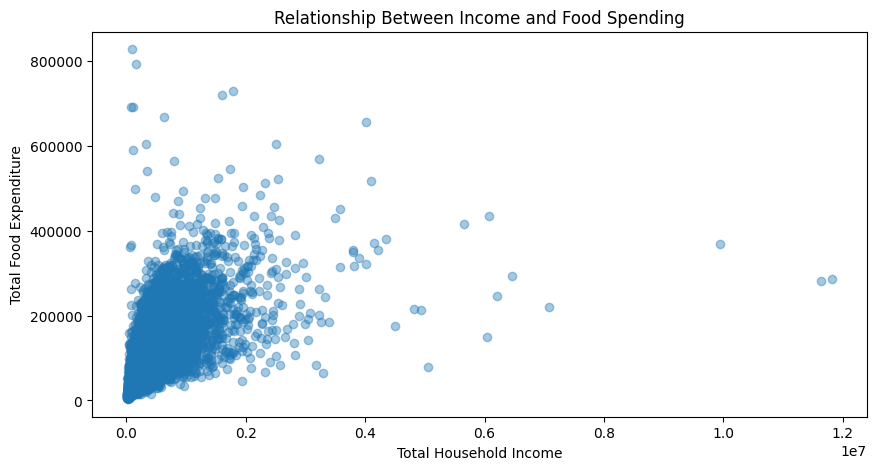

In [39]:
# 5 — Descriptive 2: Scatterplot (Income vs Food Expenditure)
plt.scatter(df["Total Household Income"], df["Total Food Expenditure"], alpha=0.4)
plt.xlabel("Total Household Income")
plt.ylabel("Total Food Expenditure")
plt.title("Relationship Between Income and Food Spending")
plt.show()


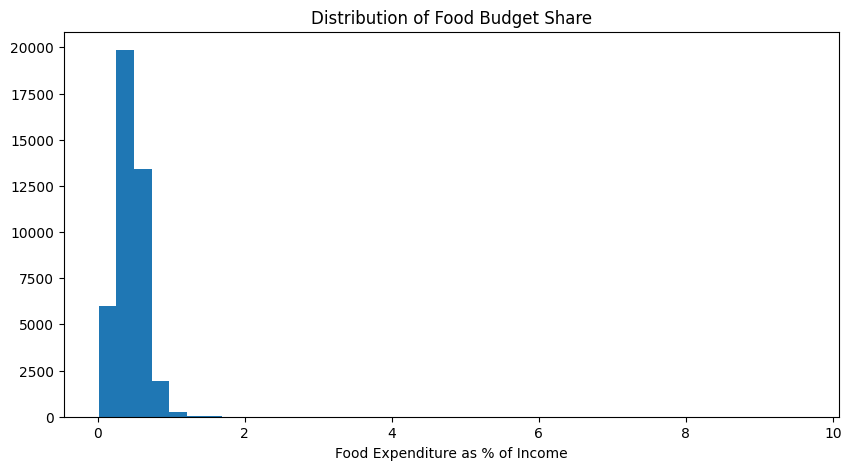

In [40]:
# 6 — Descriptive 3: Food spending share (Food Expenditure / Income)
df["Food_share"] = df["Total Food Expenditure"] / df["Total Household Income"]

plt.hist(df["Food_share"], bins=40)
plt.title("Distribution of Food Budget Share")
plt.xlabel("Food Expenditure as % of Income")
plt.show()


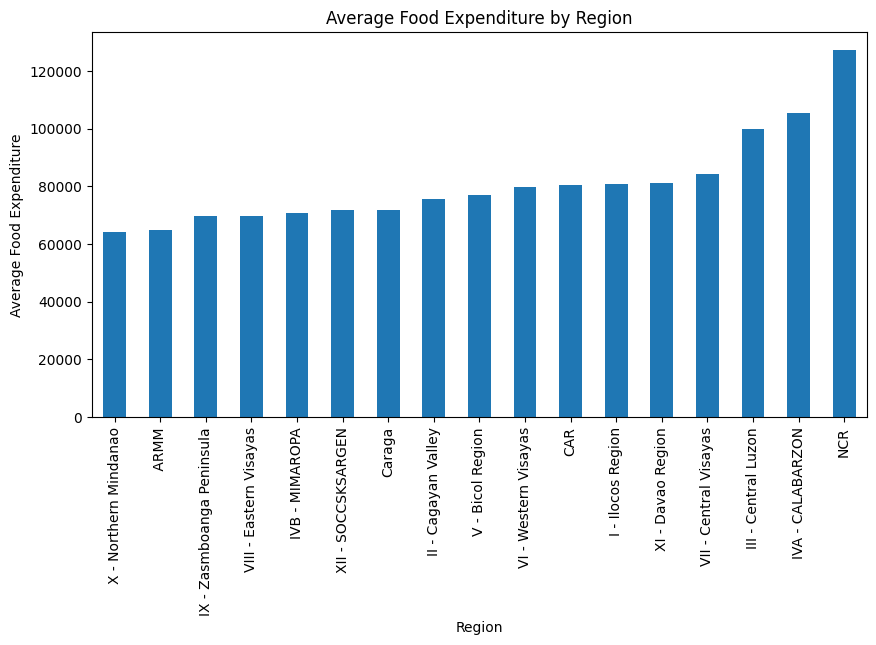

In [41]:
# 7 — Descriptive 4: Compare regions — food expenditure levels
region_food = df.groupby("Region")["Total Food Expenditure"].mean().sort_values()

region_food.plot(kind="bar")
plt.title("Average Food Expenditure by Region")
plt.ylabel("Average Food Expenditure")
plt.show()


In [54]:
df[["Region", "Household Head Occupation"]].value_counts()

Region                Household Head Occupation                                    
II - Cagayan Valley   Farmhands and laborers                                           484
CAR                   Rice farmers                                                     376
XII - SOCCSKSARGEN    Farmhands and laborers                                           361
II - Cagayan Valley   Rice farmers                                                     357
XI - Davao Region     Farmhands and laborers                                           356
                                                                                      ... 
VI - Western Visayas  Earth-moving and related plant operators                           1
XII - SOCCSKSARGEN    Trade brokers                                                      1
                      Stocks clerks                                                      1
                      Statistical, mathematical and related associate professionals      1
      

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41544 entries, 0 to 41543
Data columns (total 61 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Total Household Income                         41544 non-null  int64  
 1   Region                                         41544 non-null  object 
 2   Total Food Expenditure                         41544 non-null  int64  
 3   Main Source of Income                          41544 non-null  object 
 4   Agricultural Household indicator               41544 non-null  int64  
 5   Bread and Cereals Expenditure                  41544 non-null  int64  
 6   Total Rice Expenditure                         41544 non-null  int64  
 7   Meat Expenditure                               41544 non-null  int64  
 8   Total Fish and  marine products Expenditure    41544 non-null  int64  
 9   Fruit Expenditure                              415

In [59]:
df[df['Region'] == 'NCR']['Household Head Occupation'].value_counts()

Household Head Occupation
General managers/managing proprietors in wholesale and retail trade                    273
Car, taxi and van drivers                                                              218
General managers/managing proprietors in transportation, storage and communications    158
General managers/managing proprietors of business services                             118
Protective services workers n. e. c.                                                   107
                                                                                      ... 
Undertakers and embalmers                                                                1
Enlisted personnel n. e. c.                                                              1
Nutritionists-dietitians                                                                 1
Glass, ceramics and related plant operators n. e. c.                                     1
Other business professionals                                    

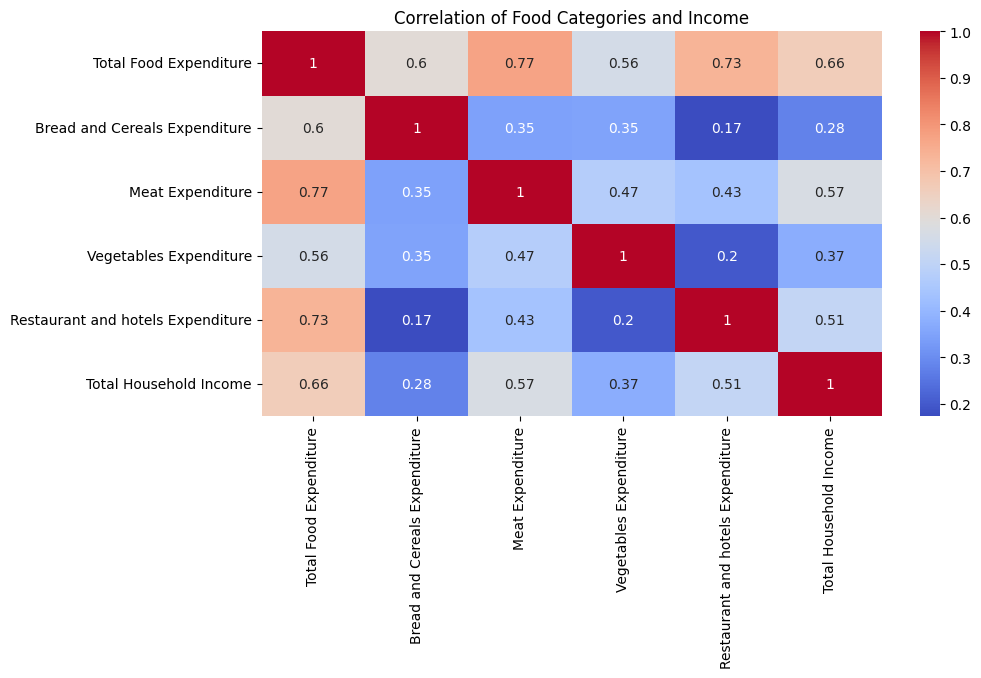

In [60]:
# 8 — Diagnostic 1: Correlation matrix for food categories
food_cols = [
    "Total Food Expenditure",
    "Bread and Cereals Expenditure",
    "Meat Expenditure",
    "Vegetables Expenditure",
    "Restaurant and hotels Expenditure",
    "Total Household Income"
]

corr = df[food_cols].corr()

sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Correlation of Food Categories and Income")
plt.show()


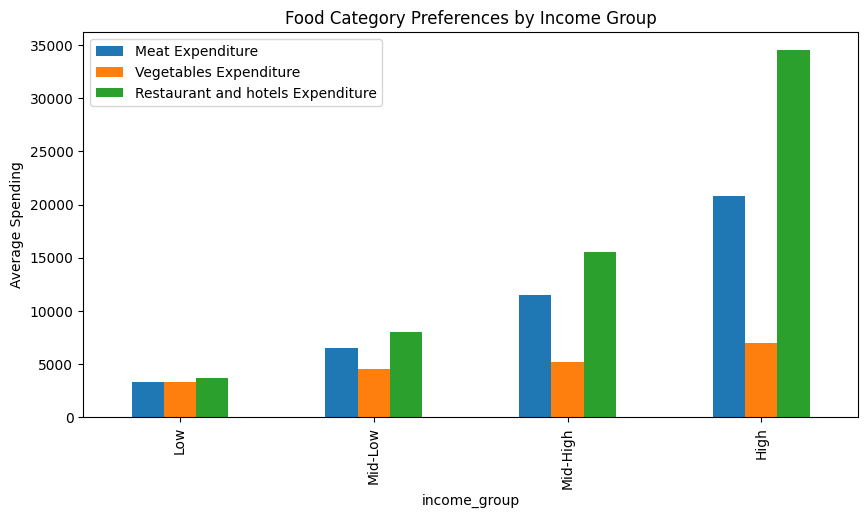

In [61]:
# 9 — Diagnostic 2: Does higher income change which food category is prioritized?
income_bins = pd.qcut(df["Total Household Income"], 4, labels=["Low", "Mid-Low", "Mid-High", "High"])

df["income_group"] = income_bins

grouped_food = df.groupby("income_group")[["Meat Expenditure", "Vegetables Expenditure", "Restaurant and hotels Expenditure"]].mean()

grouped_food.plot(kind="bar")
plt.title("Food Category Preferences by Income Group")
plt.ylabel("Average Spending")
plt.show()


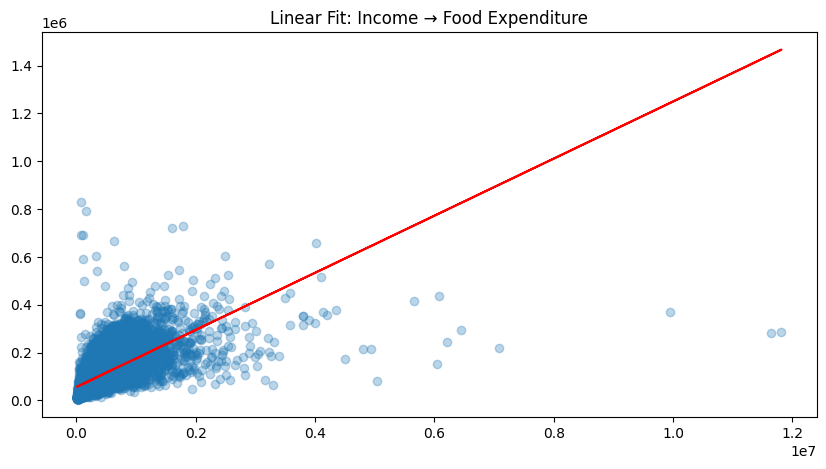

R² = 0.4404445313630996


In [62]:
# 10 — Diagnostic 3: Non-linear pattern test (quadratic curve)
x = df["Total Household Income"].values.reshape(-1,1)
y = df["Total Food Expenditure"].values

model = LinearRegression()
model.fit(x, y)
pred = model.predict(x)

plt.scatter(x,y,alpha=0.3)
plt.plot(x, pred, color="red")
plt.title("Linear Fit: Income → Food Expenditure")
plt.show()

print("R² =", r2_score(y, pred))


In [63]:
# 11 — Predictive 1: Predict food expenditure from income
X = df[["Total Household Income"]]
y = df["Total Food Expenditure"]

model2 = LinearRegression()
model2.fit(X,y)

print("Slope (increase in food spending per ₱1 income):", model2.coef_[0])
print("Intercept:", model2.intercept_)


Slope (increase in food spending per ₱1 income): 0.11945752727630643
Intercept: 55526.7801698765


In [64]:
# 12 — Predictive 2: Future scenario — if income rises by 10%
current_income = df["Total Household Income"].mean()
future_income = current_income * 1.10

future_food = model2.predict([[future_income]])[0]

print("Current average income:", round(current_income,2))
print("Predicted food spending if income +10%:", round(future_food,2))


Current average income: 247555.58
Predicted food spending if income +10%: 88056.4


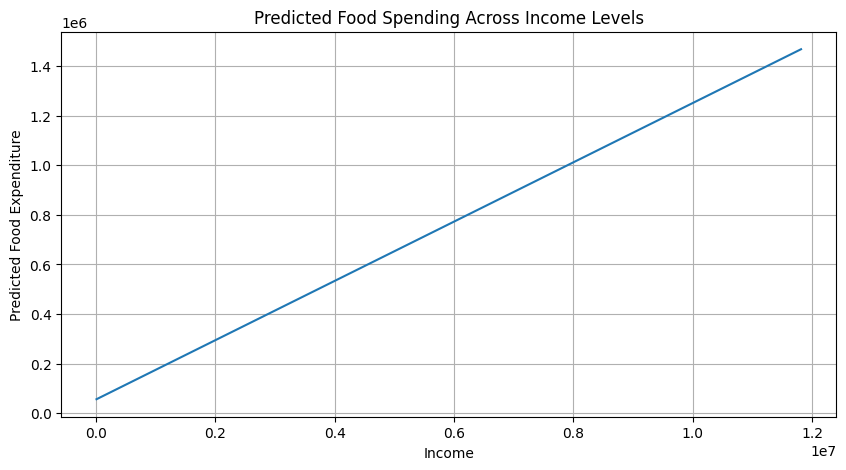

In [65]:
# 13 — Predictive 3: Prediction curve (smooth line)
income_range = np.linspace(df["Total Household Income"].min(),
                           df["Total Household Income"].max(),
                           200).reshape(-1,1)

pred_curve = model2.predict(income_range)

plt.plot(income_range, pred_curve)
plt.xlabel("Income")
plt.ylabel("Predicted Food Expenditure")
plt.title("Predicted Food Spending Across Income Levels")
plt.grid(True)
plt.show()
